In [1]:
from scipy import stats
pd.options.mode.chained_assignment = None
from scipy import stats
import random

Function

In [2]:
def safediv(n, d):
    return n/d if d!=0 else np.nan

def between(array, minv, maxv):
    return [v>=minv and v<maxv for v in array]

def get_overlap(df):
    svars = ["cpgi1", "cpgi2", "prdm9", "crossover"]
    ser = pd.Series([safediv(sum(df[v].between(0,500)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
#    print([(sum(df[v].between(0,500)), sum(df[v].between(0,1e10))) 
#                     for v in svars])
    ser.index = svars
    return ser

def percentile_of_vars(df, svars):
    og = df[df.kind=="original"]
    shuf = df[df.kind!="original"]
    res = []
    for v in svars:
        shuf_vs = shuf[v].values
        og_v = og[v].values[0]
        perc = stats.percentileofscore(shuf_vs, og_v)    
        low = np.percentile(shuf_vs, 2.5)
        high = np.percentile(shuf_vs, 97.5)
        res.append([low, high, og_v, perc, v])
    res_df = pd.DataFrame(res)
    res_df.columns = ["low", "high", "og", "percentile", "feature"]
    return res_df

def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    margin = 2e-3
    perc = stats.percentileofscore(shuf, og) # kind="strict"
    r = sum([1 for u in v if u>=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    rnd = random.uniform(0,0.2)
    N = list(y)[0]
    ax = plt.gca()
    trans = transforms.blended_transform_factory(
    ax.transData,
    ax.transAxes  # For x
    )

    # Use the transform in the annotation
    #ax.annotate('Test', xy=(0.5, 2), xycoords=trans, ha='center', va='center')
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og -margin, 0.9), xycoords=trans, **kwargs)#0.78
    plt.annotate("n={}".format(N), xy=(og -margin, 0.85), xycoords=trans, **kwargs)# 0.73

Read data

In [3]:
d = pd.read_csv("../results/merged.closeshuf.tab.gz", sep="\t", header=None, engine="pyarrow")
d.columns = ["scaf", "start", "end", "heat", "spot_id", "cpgi1", "cpgi2", "prdm9", "crossover", "kind", "spot", "species"]
svars = ["cpgi1", "cpgi2", "prdm9", "crossover"]

In [4]:
d["kind"] = d.kind.astype(str)

In [5]:
rep_counts = d.groupby(["species", "spot", "kind"])["heat"].count().reset_index()

In [6]:
rep_counts.heat.unique()

array([13566])

Annotate micro and macro

In [7]:
ctypes = pd.read_csv("../../micro_macro/corn_macro_micro_dnazoo.tab",sep="\t").set_index("scaf")["nature"].to_dict()
d["ctype"] = [ctypes[scaf] if scaf in ctypes else "unk" for scaf in d.scaf]
d["ctype"] = [r.ctype if r.species=="corn" else "macro" if "ma" in r.scaf else "micro" for i,r in d.iterrows()]

Overlap with features

In [8]:
group_vars = ["species", "kind", "spot"]
results = d.groupby(group_vars).apply(get_overlap).reset_index()

Conditional on distance to a second feature

In [16]:
#cs = d.groupby(["species", "kind", "spot"])["heat"].count().reset_index()

In [40]:
def calculate_overlap(df, feat, close):
    ecdfs = []
    for rep,ssdf in df.groupby("kind"):
        counts = len(ssdf)
        frac_overlap = safediv(sum(ssdf[feat].between(0,close)), 
                               sum(ssdf[feat].between(0,1e10)))
        ecdfs.append([rep, frac_overlap, feat, counts])

    res = pd.DataFrame(ecdfs)
    res.columns = ["rep", "frac", "feat", "counts"]
    return res

def condition_far(df, feat, far):
    og = df[df.kind=="original"]
    shuf = df[df.kind!="original"]
    keep = og[og[feat]>=far].spot_id.values
    return df[df.spot_id.isin(keep)]

close = 500
far = 10e3
feats = ["prdm9", "cpgi2", "crossover"]
cond = {"prdm9":"cpgi2", "cpgi2":"prdm9", "crossover":"cpgi2"}

dat = pd.DataFrame()
for feat in feats:
    for spot in ["hotspots", "coldspots"]:
        subd = d[d.spot==spot]
        res_all = calculate_overlap(subd, feat, close)
        res_all["cond"] = "all"
        res_all["spot"] = spot
        res_con = calculate_overlap(condition_far(subd, cond[feat], far), feat, close)
        res_con["cond"] = "cond"
        res_con["spot"] = spot
        dat = pd.concat([dat, res_all, res_con])

In [91]:
def shuf_histplot(x, **kwargs):
    v = list(x)
    if max(v)*65%2==0:
        b = 18
    else:
        b = 17
    sns.histplot(v, element="step",stat="probability", 
                 common_norm=False, bins = b, line_kws={'linestyle': '--'},
                 **kwargs)
    
def og_avline(x, **kwargs):
    v = list(x)
    plt.axvline(x=v[-1], **kwargs)
    
def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[-1]
    shuf = v[:-1]
    margin = 2e-3
    perc = stats.percentileofscore(shuf, og)
    r = sum([1 for u in v if u>=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    rnd = random.uniform(0,0.2)
    N = list(y)[0]
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og-margin,0.155), **kwargs)#0.78
    plt.annotate("n={}".format(N), xy=(og-margin,0.145), **kwargs)# 0.73

pvalue 0.001996007984031936 1 501
pvalue 0.001996007984031936 1 501
pvalue 0.001996007984031936 1 501
pvalue 0.001996007984031936 1 501
pvalue 0.001996007984031936 1 501
pvalue 0.1536926147704591 77 501
pvalue 0.6107784431137725 306 501
pvalue 0.6147704590818364 308 501
pvalue 1.0 501 501
pvalue 0.3473053892215569 174 501
pvalue 1.0 501 501
pvalue 0.9880239520958084 495 501


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seab

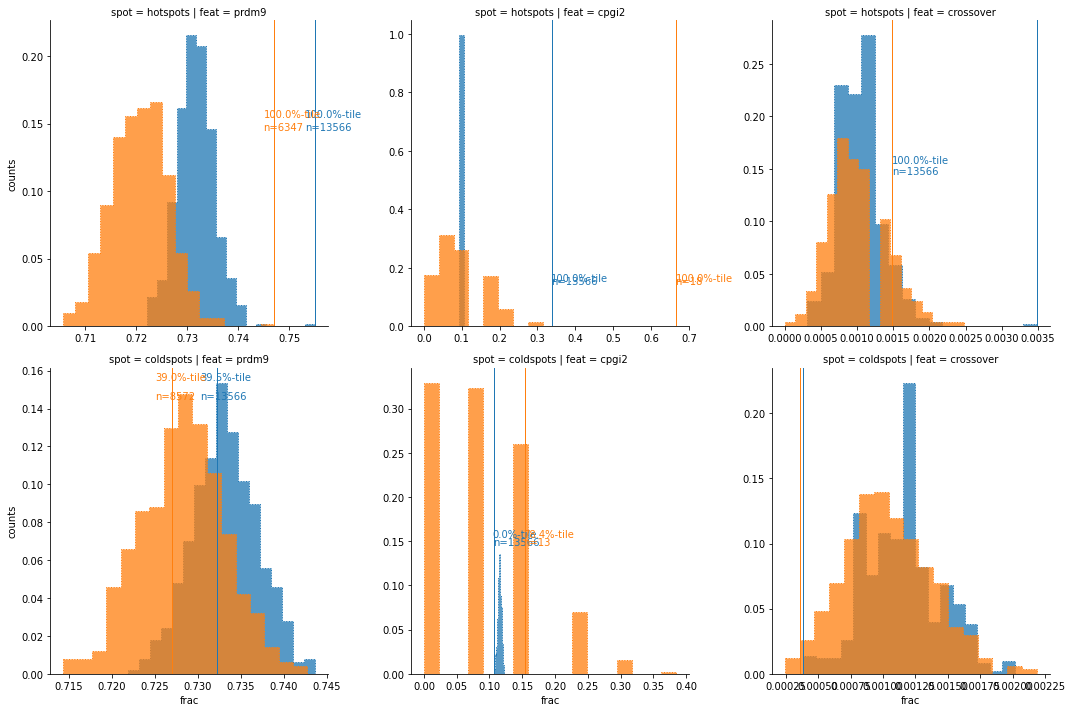

In [92]:
g = sns.FacetGrid(data=dat, col="feat", row="spot", hue="cond", height=5, legend_out=False, sharex=False, sharey=False)
g.map(shuf_histplot, "frac", linestyle="dotted")
g.map(og_avline, "frac", linewidth=1)
g.map(annotate_perc, "frac", "counts")

In [9]:
cond_dist_pairing = {"cpgi1":"prdm9", 
                     "cpgi2":"prdm9", 
                     "prdm9":"cpgi2", 
                     "crossover":"cpgi2"}

og_d = d[d.kind=="original"]
far_d = 10e3

group_vars_nokind = [g for g in group_vars if g!="kind"]
print(group_vars_nokind)
counts = {}
counts["all"] = og_d.groupby(group_vars_nokind)["scaf"].count().to_dict()

for v in svars:
    cond_dist = cond_dist_pairing[v]
    cond_og_df = og_d[og_d[cond_dist]>=far_d]
    #cond_of_hot = cond_og_df[cond_og_df.spot=="hotspots"]
    #counts[cond_dist] = cond_og_df.groupby(group_vars_nokind)["scaf"].count().to_dict()
    keep_ids = cond_og_df.spot_id.unique()
    print(v, len(keep_ids), cond_og_df.groupby("spot").size())
    seld = d[d.spot_id.isin(keep_ids)]
    print(len(seld))
    cond_res = seld.groupby(group_vars).apply(get_overlap).reset_index()
    results = results.set_index(group_vars).join(cond_res.set_index(group_vars)[v], rsuffix="_cond").reset_index()

['species', 'spot']
cpgi1 31 spot
coldspots    13
hotspots     18
dtype: int64
15531
cpgi2 31 spot
coldspots    13
hotspots     18
dtype: int64
15531
prdm9 14919 spot
coldspots    8572
hotspots     6347
dtype: int64
7474419
crossover 14919 spot
coldspots    8572
hotspots     6347
dtype: int64
7474419


In [10]:
subd = seld[(seld.spot=="hotspots") & (seld.kind=="original")]

In [11]:
corn = results[results.species=="corn"]

prdm9_cond
cpgi2_cond


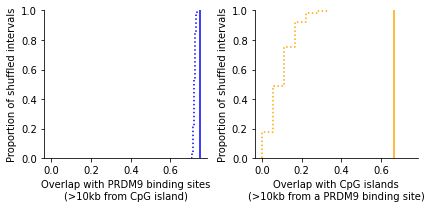

In [12]:
f,ax = plt.subplots(1,2, figsize=[6,3], sharex=True)
shuf = corn[(corn.kind!="original") & (corn.spot=="hotspots")]
orig = corn[(corn.kind=="original") & (corn.spot=="hotspots")]

spots = ["coldspots", "hotspots"]
labels = ["Overlap with PRDM9 binding sites\n(>10kb from CpG island)", 
          "Overlap with CpG islands\n(>10kb from a PRDM9 binding site)"]

palettes = {"prdm9_cond":{"hotspots":"blue"}, 
            "cpgi2_cond":{"hotspots":"orange"}}

for i,v in enumerate(["prdm9_cond", "cpgi2_cond"]):
    print(v)
    g = sns.ecdfplot(data=shuf, x=v,
                     hue="spot", 
                     palette = palettes[v],
                     linestyle="dotted", 
                     legend=False,
                     ax=ax[i])
    for isp,sp in enumerate(["hotspots"]):
        o = orig[orig.spot==sp][v].values[0]
        perc = stats.percentileofscore(shuf[v], o)
        ax[i].axvline(x=o, c=palettes[v][sp])
    
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel("Proportion of shuffled intervals")

plt.tight_layout()
sns.despine()
#plt.savefig("pdfs/overlap_spots_new_nocold.pdf")

In [3]:
corn = pd.read_csv("allhots.csv")
#corn = pd.read_csv("kmer11.csv")

174 500
0.3473053892215569
1 500
0.001996007984031936


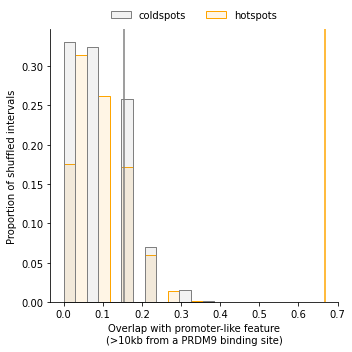

In [18]:
f,ax = plt.subplots(figsize=[5,5])
shuf = corn[corn.kind!="original"]
orig = corn[corn.kind=="original"]

spots = ["coldspots", "hotspots"]
labels = ["Overlap with all PRDM9 binding sites\n(>10kb from a promoter-like feature)", 
          "Overlap with promoter-like feature\n(>10kb from a PRDM9 binding site)"]

palettes = {"prdm9_cond":{"hotspots":"blue", "coldspots":"gray"}, 
            "cpgi2_cond":{"hotspots":"orange", "coldspots":"gray"}}

for i,v in enumerate(["cpgi2_cond"]):
    g = sns.histplot(data=shuf, x=v,
                     hue="spot", 
                     hue_order=spots,
                     palette = palettes[v],
                     element="step",
                     stat="probability", 
                     common_norm=False,
                     alpha = 0.1,
                     ax=ax)
    #legend = False if i==1 else True,
#    if i==0:
    sns.move_legend(ax, "lower center",
                    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    g.legend_.set_title(None)
    for isp,sp in enumerate(spots):
        o = orig[orig.spot==sp][v].values[0]
        s = shuf[shuf.spot==sp]
        perc = stats.percentileofscore(s[v], o)
        made = 1 + sum([1 for k in s[v] if k>=o])
        print(made, len(s))
        print(made / (len(s) + 1))
        #print(o, perc, v, sp)
        #print(s[v].min(), s[v].max())
        #print(np.percentile(s[v], 2.5), np.percentile(s[v], 97.5))
        ax.axvline(x=o, c=palettes[v][sp])
    
    ax.set_xlabel(labels[i+1])
    ax.set_ylabel("Proportion of shuffled intervals")

plt.tight_layout()
sns.despine()
plt.savefig("pdfs/hotspot_overlap_all_cpgi.pdf")
plt.savefig("pdfs/hotspot_overlap_all_cpgi.jpg", dpi=400)

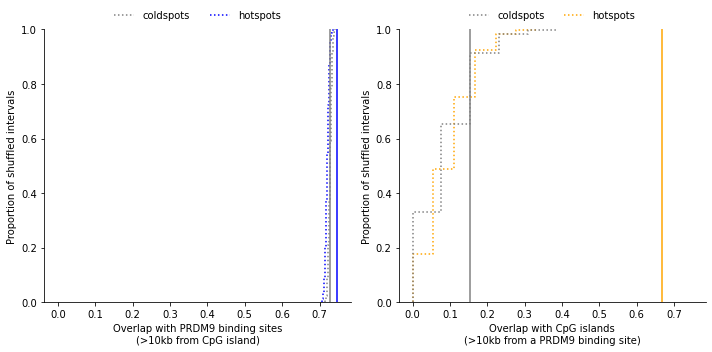

In [42]:
f,ax = plt.subplots(1,2, figsize=[10,5], sharex=True)
shuf = corn[corn.kind!="original"]
orig = corn[corn.kind=="original"]

spots = ["coldspots", "hotspots"]
labels = ["Overlap with PRDM9 binding sites\n(>10kb from CpG island)", 
          "Overlap with CpG islands\n(>10kb from a PRDM9 binding site)"]

palettes = {"prdm9_cond":{"hotspots":"blue", "coldspots":"gray"}, 
            "cpgi2_cond":{"hotspots":"orange", "coldspots":"gray"}}
for i,v in enumerate(["prdm9_cond", "cpgi2_cond"]):
    g = sns.ecdfplot(data=shuf, x=v,
                     hue="spot", 
                     hue_order=spots,
                     palette = palettes[v],
                     linestyle="dotted", 
                     ax=ax[i])
    #legend = False if i==1 else True,
#    if i==0:
    sns.move_legend(ax[i], "lower center",
                    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)
    g.legend_.set_title(None)
    for isp,sp in enumerate(spots):
        o = orig[orig.spot==sp][v].values[0]
        perc = stats.percentileofscore(shuf[v], o)
        ax[i].axvline(x=o, c=palettes[v][sp])
    
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel("Proportion of shuffled intervals")

plt.tight_layout()
sns.despine()
#plt.savefig("pdfs/overlap_spots_prdm9_union.pdf")

100.0


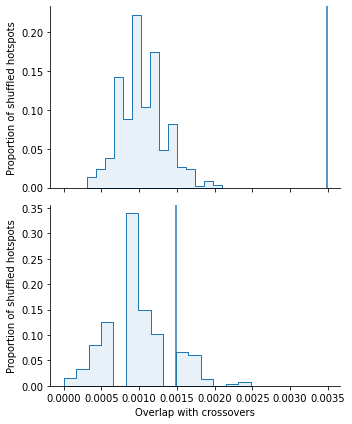

In [43]:
f,axs = plt.subplots(2,1, sharex=True, figsize=[5,6])

hot = corn[corn.spot=="hotspots"]
shuf = hot[hot.kind!="original"]
orig = hot[hot.kind=="original"]

bins = 15
ax = axs[0]
v = "crossover"
g = sns.histplot(data=shuf, x=v,
                 element="step",stat="probability", 
                 common_norm=False,
                 bins = bins,
                 alpha = 0.1,
                 ax=ax)

o = orig[v].values[0]
perc = stats.percentileofscore(shuf[v], o)
print(perc)
ax.axvline(x=o)
    
ax.set_xlabel("Overlap with crossovers")
ax.set_ylabel("Proportion of shuffled hotspots")

ax = axs[1]
v = "crossover_cond"
g = sns.histplot(data=shuf, x=v,
                 element="step",stat="probability", 
                 common_norm=False,
                 bins = bins,
                 alpha = 0.1,
                 ax=ax)

o = orig[v].values[0]
perc = stats.percentileofscore(shuf[v], o)
ax.axvline(x=o)
    
ax.set_xlabel("Overlap with crossovers")
ax.set_ylabel("Proportion of shuffled hotspots")

plt.tight_layout()
sns.despine()

Final figure

In [35]:
union = pd.read_csv("allbsites.csv")
kmer = pd.read_csv("kmer11.csv")

In [68]:
labels = ["Overlap between spots far from promoter-like features\nand all predicted PRDM9 binding sites\n", 
          "Overlap between spots far from promoter-like features\nand PRDM9-11ZF_Kmer predicted binding sites"]

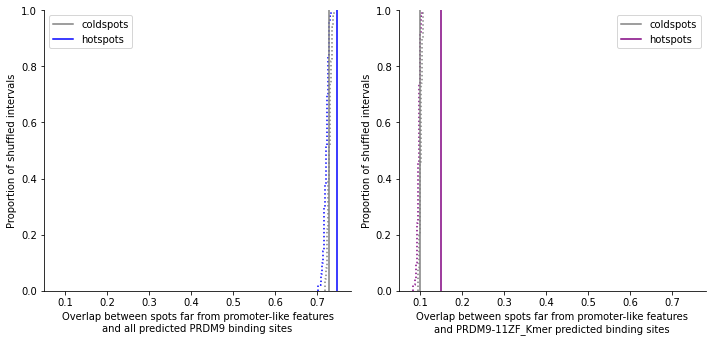

In [70]:
f,ax = plt.subplots(1,2, figsize=[10,5], sharex=True)

spots = ["coldspots", "hotspots"]
palettes = [{'prdm9_cond': {'hotspots': 'blue', 'coldspots': 'gray'}}, 
            {'prdm9_cond': {'hotspots': 'purple', 'coldspots': 'gray'}}]

for i,df in enumerate([union, kmer]):

    shuf = df[df.kind!="original"]
    orig = df[df.kind=="original"]

    v = "prdm9_cond"
    g = sns.ecdfplot(data=shuf, x=v,
                     hue="spot", 
                     hue_order=spots,
                     palette = palettes[i][v],
                     linestyle="dotted", 
                     ax=ax[i])
    sns.move_legend(ax[i], "lower center",
                    bbox_to_anchor=(.5, 1), ncol=3, 
                    title=None, frameon=False)
    g.legend_.set_title(None)

    for isp,sp in enumerate(spots):
        o = orig[orig.spot==sp][v].values[0]
        perc = stats.percentileofscore(shuf[v], o)
        ax[i].axvline(x=o, c=palettes[i][v][sp], label=sp)
    ax[i].legend()

    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel("Proportion of shuffled intervals")

plt.tight_layout()
sns.despine()
plt.savefig("pdfs/spots_far_promoter_features_union_11ZF.pdf")

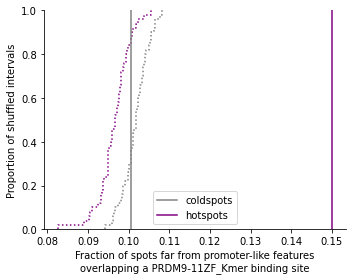

In [79]:
f,ax = plt.subplots(figsize=[5,4])

df = kmer
shuf = df[df.kind!="original"]
orig = df[df.kind=="original"]

v = "prdm9_cond"
g = sns.ecdfplot(data=shuf, x=v,
                 hue="spot", 
                 hue_order=spots,
                 palette = palettes[i][v],
                 linestyle="dotted", 
                 ax=ax)
sns.move_legend(ax, "lower center",
                bbox_to_anchor=(.5, 1), ncol=3, 
                title=None, frameon=False)
g.legend_.set_title(None)

for isp,sp in enumerate(spots):
    o = orig[orig.spot==sp][v].values[0]
    perc = stats.percentileofscore(shuf[v], o)
    ax.axvline(x=o, c=palettes[i][v][sp], label=sp)
ax.legend()

ax.set_xlabel("Fraction of spots far from promoter-like features\noverlapping a PRDM9-11ZF_Kmer binding site")
ax.set_ylabel("Proportion of shuffled intervals")
plt.tight_layout()
sns.despine()
plt.savefig("pdfs/spots_far_promoter_features_11ZF.pdf")

In [8]:
hots = pd.read_csv("../spots/corn.heat.bed",sep="\t", header=None)
hots.columns = ["scaf", "start", "end", "bah", "heat"]

In [10]:
hots["width"] = hots.end - hots.start

In [12]:
heat    = hots.heat.median()
hot_w   = hots.width.median()
hot_n   = len(hots)
auto_bp = 1.6e9
hot_f   = (hot_w*hot_n)/auto_bp


(heat*hot_f)/((heat*hot_f) + (1-hot_f))

0.18398851342367123

Only get percentiles and ranges in shuffled sets

In [7]:
total_vars = svars + ["{}_cond".format(v) for v in svars]
percs = results.groupby(group_vars_nokind).apply(lambda x: percentile_of_vars(df=x, svars=total_vars)).reset_index()
percs["id"] = [":".join(v) for v in percs[group_vars_nokind + ["feature"]].values]
percs["cond"] = ["all" if "cond" not in var else cond_dist_pairing[var.replace("_cond","")] for var in percs.feature]
percs["n"] = [counts[r.cond][tuple(r[v] for v in group_vars_nokind)] if tuple(r[v] for v in group_vars_nokind) in counts[r.cond] else 0 for i,r in percs.iterrows()]
percs["ctype_spot"] = percs.spot + " - " + percs.ctype

Plot

In [8]:
sq_res = results.melt(id_vars=group_vars, value_vars=total_vars)
sq_res["id"] = [":".join(v) for v in sq_res[group_vars_nokind + ["variable"]].values]
sq_res["cond"] = ["all" if "cond" not in var else cond_dist_pairing[var.replace("_cond","")] for var in sq_res.variable]

In [9]:
sign = percs[percs.percentile>97.5]
high_out = list(sign.id)
sign = percs[percs.percentile<2.5]
low_out = list(sign.id)

In [10]:
kind_class = []
for i,r in sq_res.iterrows():
    if r.kind!="original":
        kind_class.append("shuf")
    else:
        id_s = r.id
        if id_s in high_out:
            kind_class.append("og_high")
        elif id_s in low_out:
            kind_class.append("og_low")
        else:
            kind_class.append("og_nonoutlier")
sq_res["kind_class"] = kind_class

In [75]:
def annotate_counts(x, y, order, *args, **kwargs):
    if kwargs["label"]=="shuf":
        df = pd.DataFrame([list(x),list(y)]).transpose()
        for feature,sdf in df.groupby(1):
            ns = sdf[0].values[0]
            plt.annotate(ns, xy=(-0.03, 
                                 order.index(feature)), 
                         va="center", 
                         ha="right",
                         fontsize=8)
        #print(pd.DataFrame([x, y]))
        #print(set(y))
        #plt.scatter(x, y)

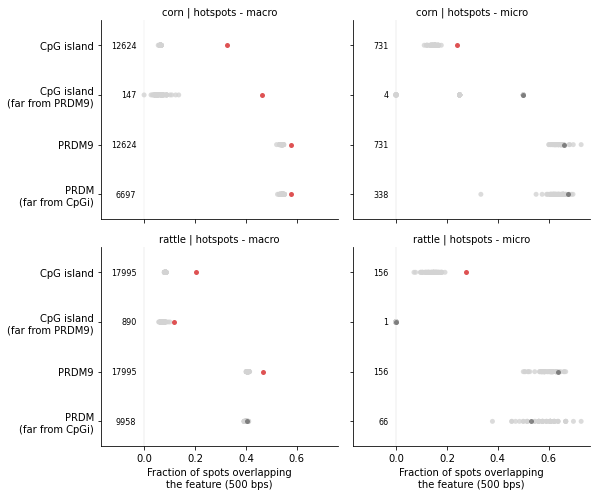

In [80]:
palette = {"shuf":"lightgray", 
           "og_high":"C3", 
           "og_nonoutlier":"dimgray", 
           "og_low":"C0"}

replacement = {'cpgi2':"CpG island", 
               'cpgi2_cond':"CpG island\n(far from PRDM9)", 
               'prdm9':"PRDM9", 
               'prdm9_cond':"PRDM\n(far from CpGi)", 
               'crossover':"Crossover", 
               'crossover_cond':"Crossover\n(far from CpGi)"}

sq_res["ctype_spot"] = sq_res.spot + " - " + sq_res.ctype
subd = sq_res[(sq_res.ctype!="unk") & (sq_res.value<1)]
subd["n"] = [counts[r.cond][tuple(r[v] for v in group_vars_nokind)] for i,r in subd.iterrows()]
subd = subd[(subd.spot=="hotspots") & 
            (~subd.variable.str.contains("cpgi1")) & 
            (~subd.variable.str.contains("cross"))]

subd["variable"] = [replacement[v] for v in subd.variable]

g = sns.FacetGrid(data = subd, 
                  row="species", col="ctype_spot", 
                  hue="kind_class", 
                  height = 3.5, aspect = 1.2,
                  palette=palette)

svars = ["cpgi2","prdm9"]
order = sum([[replacement[v],replacement["{}_cond".format(v)]] for v in svars], [])

g.map(sns.stripplot, "value", "variable", 
      alpha=0.8, order=order, jitter=0, s=5)
g.map(annotate_counts, "n", "variable", 
      order=order)
g.map(plt.axvline, x=0, 
      color="gray", 
      linewidth=0.1, 
      linestyle="dotted")

g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_axis_labels("Fraction of spots overlapping\nthe feature (500 bps)", "")
g.set(xlim=(-0.17, None))
g.tight_layout()
g.savefig("pdfs/expected_overlap_features_shuf_macromicro_counts_onlyhots.jpg", dpi=400)